In [1]:
import faraday_rotation as fr
import matplotlib.pyplot as plt
import numpy as np

In [2]:
#%qtconsole

In [3]:
# target settings:
x_s = 0 # start position in x direction, in micron
x_e = 7.2 # end position in x direction, in micron
y_s = -13.5 # start in y direction, in micron
y_e = 13.5 # end in y direction, in micron
target_transmission = 0.72

In [4]:
target = fr.Target(x_s, x_e, y_s, y_e, target_transmission)

In [5]:
# simulation settings:
m = 1801 # Nx:grid number in x direction
n = 6040 # Ny:grid number if y direction, MUST be an even number
timestep = 16 # Number of timesteps in the simulation.
energy = 6.457 # Photon energy in keV of processed simulation file.

simulation = fr.Simulation(m, n, target, timestep, energy)

In [6]:
# optical setup:

#Transmission of all channelcuts including spectral bandwidth.
trans_channel = 0.43*0.6/0.8 

args = (10, # analyser position (mrad)
        1e-5, # polarisation impurity
        2e-7, # analyse exctinction
        6.457, # observation energy
        trans_channel, # as above
        13, # pixel size
        320, # beam width
        1e12, # initial number of photons
        30, # magnification
        1 # Transmission of CRLs due to beam size
          # mismatch (asymmetry).
       )
#analyser_position = 0.75
#polarisation_impurity = 1e-7
#analyser_exctinction = 2e-7
#observation_energy = 6.457
#trans_channel = 0.43*0.6/0.8
#pixel_size = 13
#beam_width = 320
#n_0 = 1e12
#magnification = 30
#trans_telescope = 1

config = fr.Configuration(*args)

In [7]:
# load simulation data:
path_to_file = "rotation_data/Rotation_16.dat"
#simulation.load_data(path=path_to_file)

In [8]:
#np.save('sim', simulation.data)

In [9]:

simulation.data = np.load('sim.npy')

In [10]:
experiment = fr.Detection(config, simulation)

In [11]:
experiment.calc_rotation()

In [12]:
experiment.calc_det_shape()

In [13]:
experiment.emulate_intensity()

/home/ordyna35/anaconda3/lib/python3.6/site-packages/skimage/transform/_warps.py:105: UserWarning: The default mode, 'constant', will be changed to 'reflect' in skimage 0.15.
  warn("The default mode, 'constant', will be changed to 'reflect' in "


In [14]:
experiment.cfg.calc_ph_per_px_on_axis()

160000000.0

In [15]:
experiment.calc_beam_profile()

Displaying meany images with a common norm. (One colorbar, comparable; multiply some if the range is to wide)
Look here: https://matplotlib.org/gallery/images_contours_and_fields/multi_image.html 

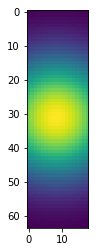

In [16]:
plt.imshow(experiment.beam_profile)

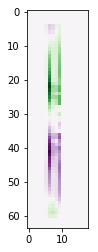

In [17]:
plt.imshow(experiment.intensity_px, cmap = 'PRGn')

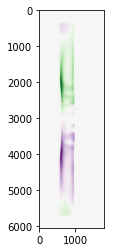

In [18]:
plt.imshow(experiment.rotation, cmap='PRGn')

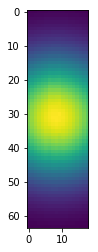

In [19]:
plt.imshow(experiment.intensity_px*experiment.beam_profile)

In [20]:
experiment.intensity_px


array([[0.00011019, 0.00011019, 0.00011019, ..., 0.00011019, 0.00011019,
        0.00011019],
       [0.00011019, 0.00011019, 0.00011019, ..., 0.00011019, 0.00011019,
        0.00011019],
       [0.00011019, 0.00011019, 0.00011019, ..., 0.00011019, 0.00011019,
        0.00011019],
       ...,
       [0.00011019, 0.00011019, 0.00011019, ..., 0.00011019, 0.00011019,
        0.00011019],
       [0.00011019, 0.00011019, 0.00011019, ..., 0.00011019, 0.00011019,
        0.00011019],
       [0.00011019, 0.00011019, 0.00011019, ..., 0.00011019, 0.00011019,
        0.00011019]])

In [21]:
experiment.ideal_detector = experiment.beam_profile*experiment.intensity_px

In [22]:
exp_with_noise = experiment.add_noise(accumulation=30)

A


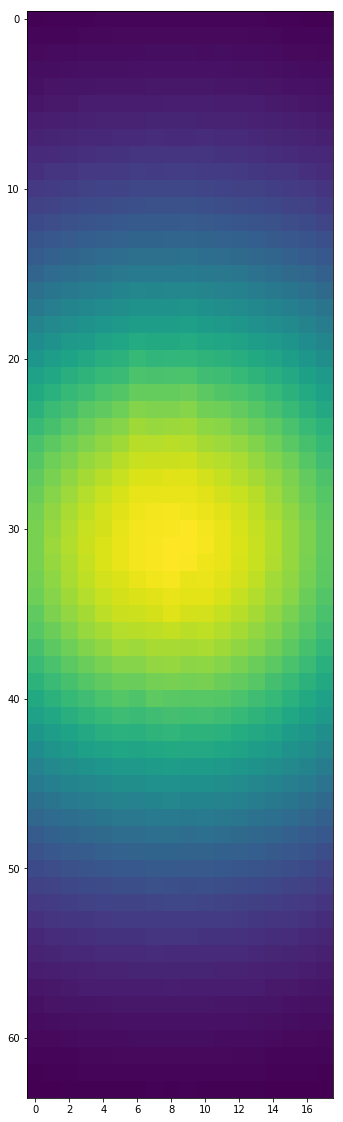

In [23]:
f, ax = plt.subplots(1,1, figsize =(20,20))
plt.imshow(exp_with_noise)

In [24]:
exp_noise_acc = experiment.add_noise(accumulation = 30)

A


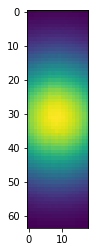

In [25]:
plt.imshow(exp_noise_acc)

(SOLVED) so photons at axis compansate with the polariser, can it be? Add noise just for the beam (no laser, rotation) and see how it looks.


In [26]:
base_noise_acc = experiment.add_noise(accumulation=30, image=experiment.beam_profile)

B


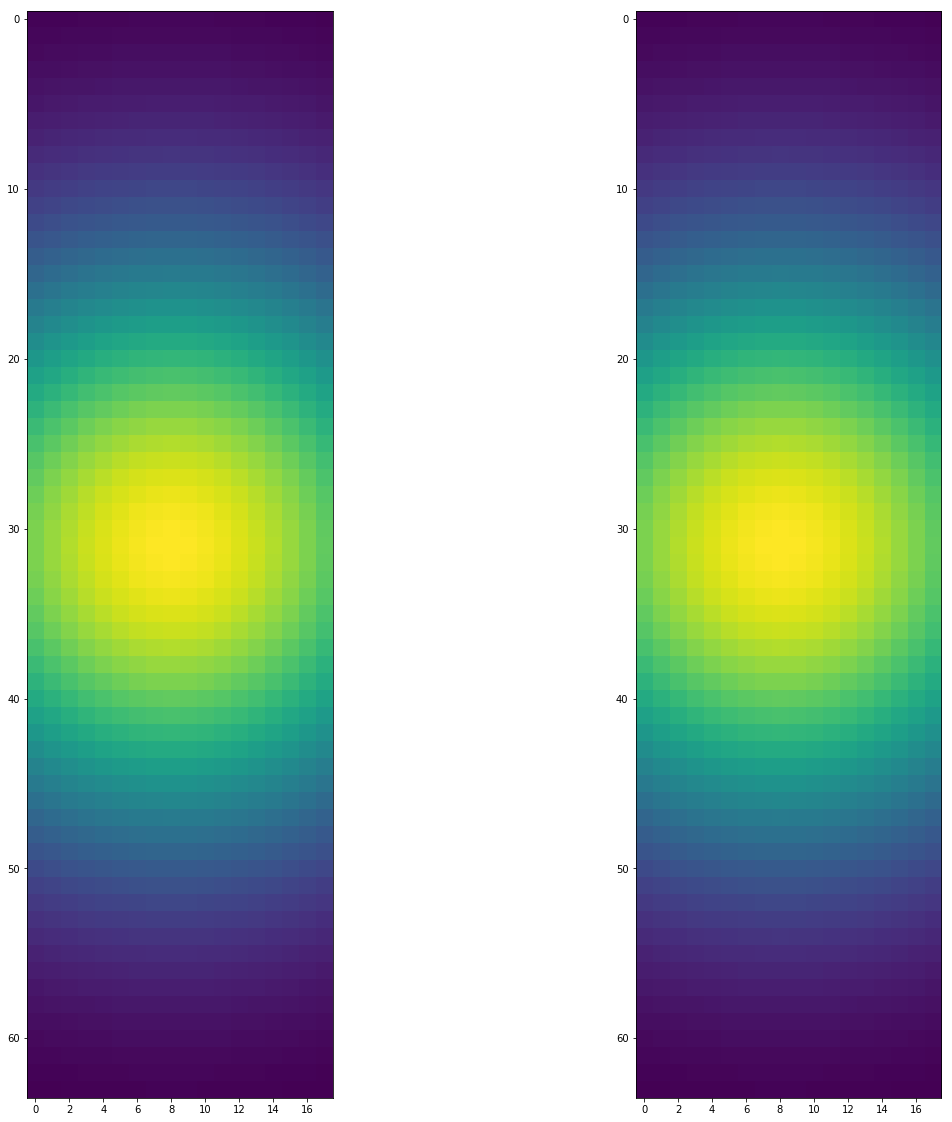

In [27]:
f, ax = plt.subplots(1,2, figsize =(20,20))
ax[0].imshow(base_noise_acc)
ax[1].imshow(experiment.beam_profile)

In [28]:
rot = experiment.reobtain_rotation(exp_noise_acc, base_noise_acc)

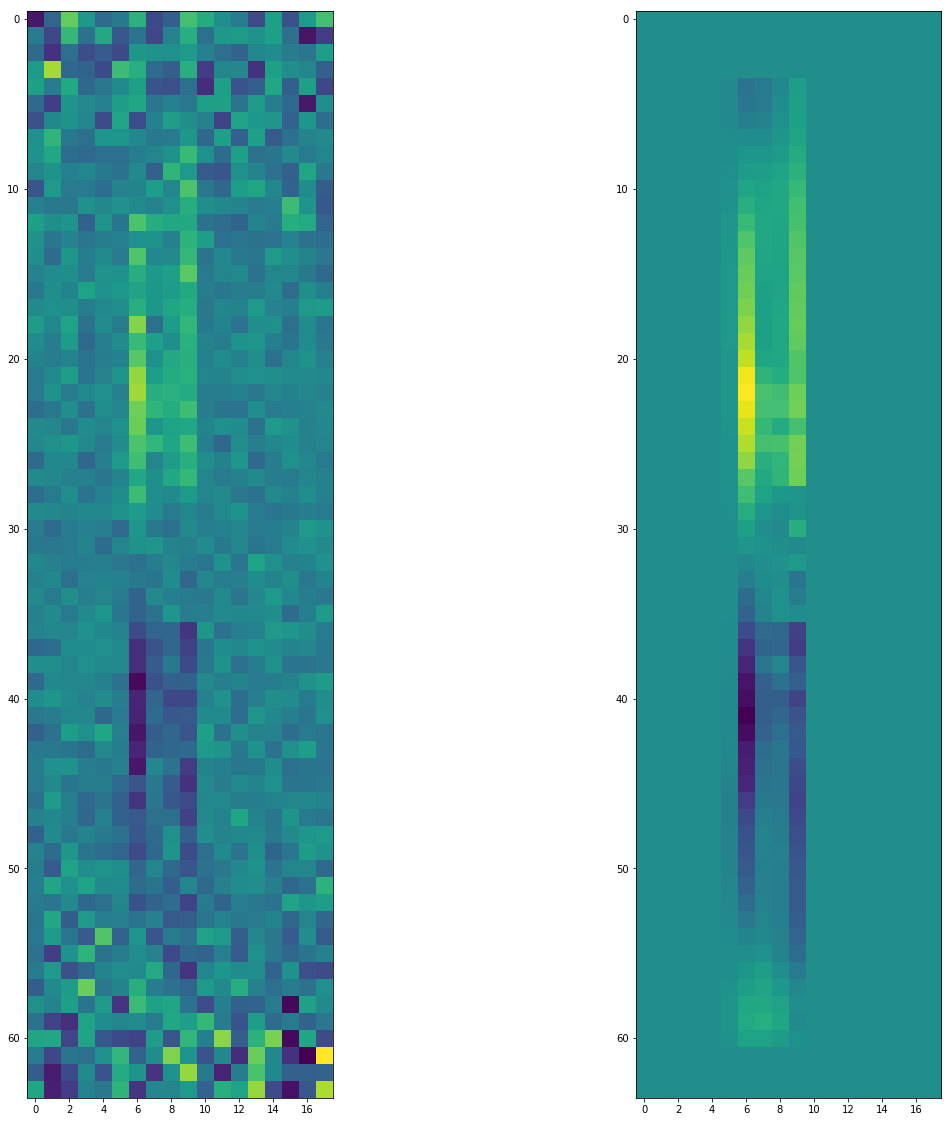

In [29]:
f, ax = plt.subplots(1,2, figsize =(20,20))
ax[0].imshow(rot)
ax[1].imshow(experiment.intensity_px)